# Continuous Evaluation and Drift Detection

In production, machine learning models don’t live in a static world. Over time:

- Input data distributions can shift (e.g., new camera lighting, background changes)  
- Model performance may degrade without any code change  
- Detecting issues early is essential for reliability and trust  

This notebook introduces **continuous evaluation**, which is the practice of:

1. Monitoring model performance over time  
2. Detecting performance degradation or “drift”  
3. Simulating retraining decisions in a production-like workflow  

In this example, we will:

- Load the 5-flowers dataset and a trained model (or train a lightweight model locally)  
- Evaluate baseline performance  
- Introduce noise to simulate data drift  
- Compare baseline vs drifted performance  
- Trigger alerts if performance drops beyond a threshold  

By the end of this notebook, you will understand **how to monitor and detect model regression**, an essential step in production-ready ML pipelines.


In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os

# Load and Preprocess Dataset

# -----------------------------
# Important: IMG_SIZE must match the model's expected input.
# - If you are loading a saved model from a previous session, keep IMG_SIZE = 128 (since that's what it used)
# - If no saved model exists and a new model is trained, you can use IMG_SIZE = 224
# Changing this incorrectly will cause shape mismatch errors!
# -----------------------------
IMG_SIZE = 128
BATCH_SIZE = 32

(ds_train, ds_val), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = ds_info.features["label"].num_classes
CLASS_NAMES = ds_info.features["label"].names

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [12]:
# Load Model (or Train Lightweight Model)

MODEL_PATH = "saved_model/flowers_model" #Update path to your saved model (or leave as-is to generate a new one)
# Example: MODEL_PATH = "..\\07_training\\model_registry\\v_20260215_185521\\" 
# --> ".." traverses one parent directory
# --> The double backslashes are needed on Windows (the first backslash protects the second from Python interpretation)

if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Loaded saved model.")
    if model.input_shape[1] != IMG_SIZE:
        print(f"⚠️ Warning: Model expects input size {model.input_shape[1]}x{model.input_shape[2]}, "
              f"but IMG_SIZE is set to {IMG_SIZE}. Resize in preprocessing accordingly!")
else:
    print("Saved model not found. Training lightweight model for demo...")
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    model.fit(ds_train, epochs=1)



Saved model not found. Training lightweight model for demo...
92/92 [==============================] - 10s 78ms/step - loss: 0.7787 - accuracy: 0.7027


In [13]:
# Evaluate Baseline Performance

baseline_loss, baseline_acc = model.evaluate(ds_val, verbose=1)
print(f"Baseline accuracy: {baseline_acc:.3f}")


23/23 [==============================] - 3s 77ms/step - loss: 0.4411 - accuracy: 0.8488
Baseline accuracy: 0.849


In [14]:
# Simulate Data Drift (Add Noise)
# We simulate a “shifted distribution” by adding Gaussian noise to images:

def add_noise(image, label, stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=stddev)
    image_noisy = tf.clip_by_value(image + noise, 0.0, 1.0)
    return image_noisy, label

ds_val_noisy = ds_val.map(lambda x, y: add_noise(x, y, stddev=0.2))


In [15]:
# Evaluate Drifted Dataset

drift_loss, drift_acc = model.evaluate(ds_val_noisy, verbose=1)
print(f"Noisy dataset accuracy: {drift_acc:.3f}")


23/23 [==============================] - 4s 154ms/step - loss: 1.3021 - accuracy: 0.5095
Noisy dataset accuracy: 0.510


In [16]:
# Detect Performance Regression

threshold_drop = 0.05  # alert if accuracy drops by more than 5%

if drift_acc < baseline_acc - threshold_drop:
    print("⚠ ALERT: Performance regression detected! Consider retraining the model.")
else:
    print("✅ Model performance is within acceptable limits.")


⚠ ALERT: Performance regression detected! Consider retraining the model.


1/1 [==============================] - 1s 759ms/step


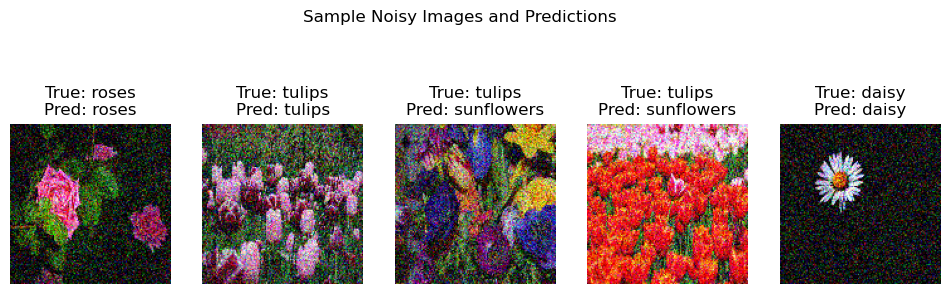

In [17]:
# Visualize Noisy Images

for images, labels in ds_val_noisy.take(1):
    images_np = images.numpy()
    labels_np = labels.numpy()
    preds = np.argmax(model.predict(images_np), axis=1)
    
    plt.figure(figsize=(12,4))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(images_np[i])
        plt.title(f"True: {CLASS_NAMES[labels_np[i]]}\nPred: {CLASS_NAMES[preds[i]]}")
        plt.axis('off')
    plt.suptitle("Sample Noisy Images and Predictions")
    plt.show()


## Notes:
- This is a simulated drift, but in production, drift could come from new camera feeds, lighting, backgrounds, or user populations.
- Continuous evaluation pipelines often log metrics over time and trigger retraining automatically.
- This demonstrates the full evaluation loop: baseline → monitor → detect drift → alert.